In [1]:
GPU = True  #set to True to use GPU for XGboost 
OPTUNA = False #set to True to run Optuna first, false to use saved hyperparameters

## XGBoost Model Testing

In [2]:
import os

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

from sklearn.model_selection import (
    StratifiedKFold, 
    TimeSeriesSplit,
)

import xgboost as xgb
print('XGB version:', xgb.__version__)

import optuna
from optuna.visualization import (
    plot_optimization_history, 
    plot_param_importances,
)

import neptune.new as neptune
from neptune.new.integrations.xgboost import NeptuneCallback
import neptune.new.integrations.optuna as optuna_utils
from neptune.new.types import File

from tqdm import tqdm

import shap

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from src.common_functions import plot_confusion_matrix

from pathlib import Path  #for Windows/Linux compatibility
DATAPATH = Path(r'data')

import ipynbname

import warnings
warnings.simplefilter('ignore')


XGB version: 1.6.2


In [3]:
TRAIN_NAME = "train_selected.csv"
TEST_NAME = "test_selected.csv"

train = pd.read_csv(DATAPATH / TRAIN_NAME)
test = pd.read_csv(DATAPATH / TEST_NAME)


In [4]:
train

GAME_DATE_EST   GAME_ID  HOME_TEAM_ID  VISITOR_TEAM_ID  SEASON  \
0        2003-10-29  20300006    1610612740       1610612737    2003   
1        2003-10-31  20300024    1610612741       1610612737    2003   
2        2003-11-05  20300060    1610612744       1610612737    2003   
3        2003-11-08  20300084    1610612757       1610612737    2003   
4        2003-11-09  20300089    1610612760       1610612737    2003   
...             ...       ...           ...              ...     ...   
23042    2021-04-28  22000936    1610612738       1610612766    2020   
23043    2021-05-04  22000984    1610612765       1610612766    2020   
23044    2021-05-15  22001064    1610612752       1610612766    2020   
23045    2021-05-16  22001080    1610612764       1610612766    2020   
23046    2021-05-18  52000111    1610612754       1610612766    2020   

       PTS_home  FG_PCT_home  FT_PCT_home  FG3_PCT_home  AST_home  REB_home  \
0          88.0        0.324        0.700         0.160      24.0      55.0   
1         100.0        0.400        0.759         0.500      27.0      53.0   
2          99.0        0.446        0.645         0.278      23.0      52.0   
3          90.0        0.425        0.900         0.500      28.0      41.0   
4          81.0        0.379        0.737         0.056      12.0      46.0   
...         ...          ...          ...           ...       ...       ...   
23042     120.0        0.478        0.773         0.375      26.0      54.0   
23043      99.0        0.459        0.600         0.281      21.0      46.0   
23044     118.0        0.511        0.800         0.432      29.0      50.0   
23045     115.0        0.484        0.810         0.323      22.0      53.0   
23046     144.0        0.552        0.800         0.457      35.0      54.0   

       PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  AST_away  REB_away  \
0          83.0        0.398        0.737         0.214      18.0      58.0   
1          94.0        0.400        0.714         0.583      22.0      48.0   
2          72.0        0.367        0.500         0.333      19.0      43.0   
3          83.0        0.438        0.786         0.100      21.0      45.0   
4          91.0        0.479        0.789         0.533      16.0      41.0   
...         ...          ...          ...           ...       ...       ...   
23042     111.0        0.425        0.750         0.371      29.0      33.0   
23043     102.0        0.409        0.750         0.258      23.0      51.0   
23044     109.0        0.382        0.750         0.265      28.0      51.0   
23045     110.0        0.394        0.917         0.311      25.0      42.0   
23046     117.0        0.457        0.760         0.300      26.0      36.0   

       HOME_TEAM_WINS  PLAYOFF  CONFERENCE_x  G_x  W_x  L_x  W_PCT_x  \
0                   1        0             0    1    1    0    1.000   
1                   1        0             0    2    1    1    0.500   
2                   1        0             1    4    2    2    0.500   
3                   1        0             1    6    3    3    0.500   
4                   0        0             1    4    3    1    0.750   
...               ...      ...           ...  ...  ...  ...      ...   
23042               1        0             0   63   33   30    0.524   
23043               0        0             0   66   19   47    0.288   
23044               1        0             0   71   40   31    0.563   
23045               1        0             0   72   34   38    0.472   
23046               1        1             0   72   34   38    0.472   

       HOME_W_x  HOME_L_x  HOME_W_PCT_x  ROAD_W_x  ROAD_L_x  ROAD_W_PCT_x  \
0             1         0        1.0000         0         0           NaN   
1             1         1        0.5000         0         0           NaN   
2             2         1        0.6665         0         1        0.0000   
3             3         1        0.7500         0         2        0.0

**Setup Neptuna.ai experiment tracking**

In [5]:
LOGGING_NOTE = "remove long term statistics"

try:
    NEPTUNE_API_TOKEN = os.environ['NEPTUNE_API_TOKEN']
except:
    raise Exception('Set environment variable NEPTUNE_API_TOKEN')
    
PROJECT = "cmunch1/nba-prediction"
PROJECT_OPTUNA = "cmunch1/nba-optuna" #for 2nd run if hyperparameters are tuned
SOURCE = ipynbname.name()
SOURCE_SPLIT = "03_train_test_split.ipynb"
SOURCE_ENG = "05_feature_engineering.ipynb"
SOURCE_SEL = "06_feature_selection.ipynb"


run = neptune.init(
    project=PROJECT,
    source_files=[SOURCE,SOURCE_SPLIT,SOURCE_ENG,SOURCE_SEL],
    api_token=NEPTUNE_API_TOKEN,
)
neptune_callback = NeptuneCallback(run=run, log_tree=[0, 1, 2,])

https://app.neptune.ai/cmunch1/nba-prediction/e/NBAP-4
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


**Logging Note**

In [6]:
run["note"] = LOGGING_NOTE
run["sys/tags"].add(["xgboost",])
run['dataset/train'] = TRAIN_NAME
run['dataset/test'] = TEST_NAME

**Options**

In [7]:
run["model/parameters/GPU"] = GPU
run["model/parameters/OPTUNA"] = OPTUNA

if OPTUNA:
    run["model/optuna/optuna_cv"] = OPTUNA_CV = "TimeSeriesSplit"
    #run["model/parameters/optuna_cv"] = OPTUNA_CV = "StratifiedKFold"    
    run["model/optuna/optuna_folds"] = OPTUNA_FOLDS = 5
    run["model/optuna/optuna_trials"] = OPTUNA_TRIALS = 250

run["model/parameters/k_folds"] = K_FOLDS = 5
run["model/parameters/seed"] = SEED = 13
run["model/parameters/num_boost_round"] = NUM_BOOST_ROUND = 2000
run["model/parameters/enable_categorical"] = ENABLE_CATEGORICAL = False

VERBOSITY = 0

STATIC_PARAMS = {
                'seed': SEED,
                'eval_metric': 'auc',
                "objective": "binary:logistic",
                'verbosity': VERBOSITY,
                }

GPU_PARAMS = {
             'tree_method': 'gpu_hist',
             'predictor': 'gpu_predictor',
             }

if GPU:
    STATIC_PARAMS = STATIC_PARAMS | GPU_PARAMS


**Fix Datatypes for smaller memory footprint**

In [8]:
def fix_datatypes(df):
    df['GAME_DATE_EST'] = pd.to_datetime(df['GAME_DATE_EST'])

    long_integer_fields = ['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON']

    #convert long integer fields to int32 from int64
    for field in long_integer_fields:
        df[field] = df[field].astype('int32')
    
    #convert the remaining int64s to int8
    for field in df.select_dtypes(include=['int64']).columns.tolist():
        df[field] = df[field].astype('int8')
        
    #convert float64s to float16s
    for field in df.select_dtypes(include=['float64']).columns.tolist():
        df[field] = df[field].astype('float16')
        
    return df

train = fix_datatypes(train)
test = fix_datatypes(test)


**Encode categoricals**

In [9]:
# To use special category feature capabalities in XGB and LGB, categoricals must be ints from 0 to N-1
# Conversion can be accomplished by simple subtraction for several features
# (these capabilities may or may not be used, but encoding does not hurt anything)

def encode_categoricals(df):
    first_team_ID = df['HOME_TEAM_ID'].min()
    first_season = df['SEASON'].min()
    
    df['HOME_TEAM_ID'] = (df['HOME_TEAM_ID'] - first_team_ID).astype('int8')
    df['VISITOR_TEAM_ID'] = (df['VISITOR_TEAM_ID'] - first_team_ID).astype('int8')
    df['SEASON'] = (df['SEASON'] - first_season).astype('int8')
    
    category_columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'HOME_TEAM_WINS', 'PLAYOFF', 'CONFERENCE_x', 'CONFERENCE_y',]
    
    if ENABLE_CATEGORICAL:
        for field in category_columns:
            df[field] = df[field].astype('category')
    
    return df

train = encode_categoricals(train)
test = encode_categoricals(test)



**Drop Features**

In [10]:
target = train['TARGET']
test_target = test['TARGET']

all_columns = train.columns.tolist()
drop_columns = ['TARGET', 'GAME_DATE_EST', 'GAME_ID', ] 
long_stats_x = [ 'G_x', 'W_x', 'L_x', 'W_PCT_x', 'HOME_W_x', 'HOME_L_x', 'HOME_W_PCT_x' , 'ROAD_W_x' , 'ROAD_L_x', 'ROAD_W_PCT_x']  
long_stats_y = [ 'G_y', 'W_y', 'L_y', 'W_PCT_y', 'HOME_W_y', 'HOME_L_y', 'HOME_W_PCT_y' , 'ROAD_W_y' , 'ROAD_L_y', 'ROAD_W_PCT_y'] 

drop_columns = drop_columns + long_stats_x 
drop_columns = drop_columns + long_stats_y 

use_columns = [item for item in all_columns if item not in drop_columns]

train = train[use_columns]
test = test[use_columns]

run["model/features"].log(use_columns)


### Optuna Hyperparameter Tuning

In [11]:
def objective(trial):

    train_oof = np.zeros((train.shape[0],))
    
    train_dmatrix = xgb.DMatrix(train, target,
                         feature_names=train.columns,
                        enable_categorical=ENABLE_CATEGORICAL)
    
    xgb_params= {       
                'num_round': trial.suggest_int('num_round', 2, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 1E-3, 1),
                'max_bin': trial.suggest_int('max_bin', 2, 1000),
                'max_depth': trial.suggest_int('max_depth', 1, 8),
                'alpha': trial.suggest_float('alpha', 1E-16, 12),
                'gamma': trial.suggest_float('gamma', 1E-16, 12),
                'reg_lambda': trial.suggest_float('reg_lambda', 1E-16, 12),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 1E-16, 1.0),
                'subsample': trial.suggest_float('subsample', 1E-16, 1.0), 
                'min_child_weight': trial.suggest_float('min_child_weight', 1E-16, 12),
                'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 15),       
                }
    
    xgb_params = xgb_params | STATIC_PARAMS
        
   #pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "evaluation-auc")
    
    if OPTUNA_CV == "StratifiedKFold": 
        kf = StratifiedKFold(n_splits=OPTUNA_FOLDS, shuffle=True, random_state=SEED)
    elif OPTUNA_CV == "TimeSeriesSplit":
        kf = TimeSeriesSplit(n_splits=OPTUNA_FOLDS)
    

    for f, (train_ind, val_ind) in (enumerate(kf.split(train, target))):

        train_df, val_df = train.iloc[train_ind], train.iloc[val_ind]
        
        train_target, val_target = target[train_ind], target[val_ind]

        train_dmatrix = xgb.DMatrix(train_df, label=train_target,enable_categorical=ENABLE_CATEGORICAL)
        val_dmatrix = xgb.DMatrix(val_df, label=val_target,enable_categorical=ENABLE_CATEGORICAL)


        model =  xgb.train(xgb_params, 
                           train_dmatrix, 
                           num_boost_round = NUM_BOOST_ROUND,
                           #callbacks=[pruning_callback],
                          )

        temp_oof = model.predict(val_dmatrix)

        train_oof[val_ind] = temp_oof

        #print(roc_auc_score(val_target, temp_oof))
    
    val_score = roc_auc_score(target, train_oof)
    
    return val_score

In [12]:
def run_optuna():
    
    #log separate Neptune run for optuna hyperameter tuning
    run2 = neptune.init(
                    project=PROJECT_OPTUNA,
                    source_files=[SOURCE,SOURCE_SPLIT,SOURCE_ENG,SOURCE_SEL],
                    api_token=NEPTUNE_API_TOKEN,
                    )
    run2["options/optuna_cv"] = OPTUNA_CV 
    run2["options/optuna_folds"] = OPTUNA_FOLDS 
    run2["options/optuna_trials"] = OPTUNA_TRIALS 
    run2["options/GPU"] = GPU
    run2["options/enable_categorical"] = ENABLE_CATEGORICAL
    run2["features"].log(use_columns)
    run2["sys/tags"].add(["xgboost",])

    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials = OPTUNA_TRIALS,)

    optuna_utils.log_study_metadata(study, run2)
    
    print("Study Best Value:",study.best_value)
    print("Study Best Params:",study.best_params)
    
    plot_optimization_history(study)
    
    plot_param_importances(study)
    
    run2["best_value"] = study.best_value
    run2["best_params"] = study.best_params
    run2["static_params"] = STATIC_PARAMS
    
    run2.stop()
    
    return study.best_params
    
    

**Set Hyperparameters**

In [13]:
if OPTUNA:
    tuned_params = run_optuna()
else:
    tuned_params = {
                  #current best hyperparameters from previous tuning:     
                    'num_round': 917, 
                    'learning_rate': 0.018780233257619766, 
                    'max_bin': 941, 
                    'max_depth': 2, 
                    'alpha': 10.915599698924975, 
                    'gamma': 4.570365632036267, 
                    'reg_lambda': 8.835161122765943, 
                    'colsample_bytree': 0.19214576688970492, 
                    'subsample': 0.9902364838077369, 
                    'min_child_weight': 11.925116978302148, 
                    'scale_pos_weight': 8,
                    }

xgb_params= STATIC_PARAMS | tuned_params

run["model/params"] = xgb_params
    

**Setup Results table**

Store key metrics for easy review later

In [14]:
results = pd.DataFrame() #record metrics for easy comparison at the end

#Load Simple Model results for later comparison
def SimpleModel(test, true):

    predict = test['HOME_WINPCT_LAST_3_HOME'].apply(lambda x: 0 if x < 0.50 else 1)
    #predict = test['HOME_W_PCT_x'].apply(lambda x: 0 if x < 0.50 else 1)
    acc_score = accuracy_score(true, predict)
    auc_score = roc_auc_score(true, predict)
    
    return acc_score , auc_score

acc_score , auc_score = SimpleModel(test, test_target)
df = {'Label': 'Simple Model', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':"N/A"}
results = results.append(df, ignore_index = True) 


### Train

In [15]:
def get_scores(target, preds):
    #for accuracy score, prediction probabilities must be convert to binary scores (Win or Lose)
    #determine optimum threshold for conveting probablities using ROC curve
    #generally 0.5 works for balanced data
    #fpr = false positive rate, tpr = true postive rate
    
    fpr, tpr, thresholds = roc_curve(target,preds)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    preds_binary = (preds > optimal_threshold).astype(int)
    
    acc_score = accuracy_score(target, preds_binary)
    auc_score = roc_auc_score(target, preds)

    print()
    print("Scores:")
    print()
    print("Accuracy Score:", acc_score)
    print("AUC Score:", auc_score)
    print("Optimal Threshold:", optimal_threshold)
    
    return preds_binary, acc_score, auc_score, optimal_threshold

In [16]:
%%time

#initialize oof arrays including Shapley values and Shapley interaction values
train_oof = np.zeros((train.shape[0],))
train_oof_shap = np.zeros((train.shape[0],train.shape[1]+1))
train_oof_shap_interact = np.zeros((train.shape[0],train.shape[1]+1,train.shape[1]+1))

   
# K-fold cross validation

kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
    
    train_df, val_df = train.iloc[train_ind], train.iloc[val_ind]
    train_target, val_target = target[train_ind], target[val_ind]

    train_dmatrix = xgb.DMatrix(train_df, label=train_target,enable_categorical=ENABLE_CATEGORICAL)
    val_dmatrix = xgb.DMatrix(val_df, label=val_target,enable_categorical=ENABLE_CATEGORICAL)

    model =  xgb.train(xgb_params, 
                       train_dmatrix, 
                       num_boost_round = NUM_BOOST_ROUND,
                      callbacks=[neptune_callback],
                      )

    temp_oof = model.predict(val_dmatrix)
    temp_oof_shap = model.predict(val_dmatrix, pred_contribs=True)
    temp_oof_shap_interact = model.predict(val_dmatrix, pred_interactions=True)

    train_oof[val_ind] = temp_oof

    train_oof_shap[val_ind, :] = temp_oof_shap
    train_oof_shap_interact[val_ind, :,:] = temp_oof_shap_interact
    
    temp_oof_binary, acc_score, auc_score, optimal_threshold = get_scores(val_target, temp_oof)

# Out-of-Fold composite for train data

train_oof_binary, acc_score, auc_score, optimal_threshold = get_scores(target,train_oof)

run["train/accuracy"] = acc_score 
run["train/AUC"] = auc_score 
run["train/optimal_threshold"] = optimal_threshold

df = {'Label': 'Train', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':optimal_threshold}
results = results.append(df, ignore_index = True)            

1it [00:03,  3.84s/it]


Scores:

Accuracy Score: 0.5919739696312365
AUC Score: 0.6065025212282408
Optimal Threshold: 0.9186488


2it [00:07,  3.57s/it]


Scores:

Accuracy Score: 0.6039045553145336
AUC Score: 0.6279432442448021
Optimal Threshold: 0.91832364


3it [00:10,  3.53s/it]


Scores:

Accuracy Score: 0.6055543501844218
AUC Score: 0.6256461732423035
Optimal Threshold: 0.91338366


4it [00:14,  3.51s/it]


Scores:

Accuracy Score: 0.612931221523107
AUC Score: 0.6230577086734619
Optimal Threshold: 0.9152081


5it [00:17,  3.55s/it]


Scores:

Accuracy Score: 0.6001301800824473
AUC Score: 0.6319184378049456
Optimal Threshold: 0.920249

Scores:

Accuracy Score: 0.594350674708205
AUC Score: 0.6225838521082852
Optimal Threshold: 0.9203412532806396
CPU times: total: 31.7 s
Wall time: 17.8 s


**OOF Confusion Matrix**

[[5448 3936]
 [5413 8250]]


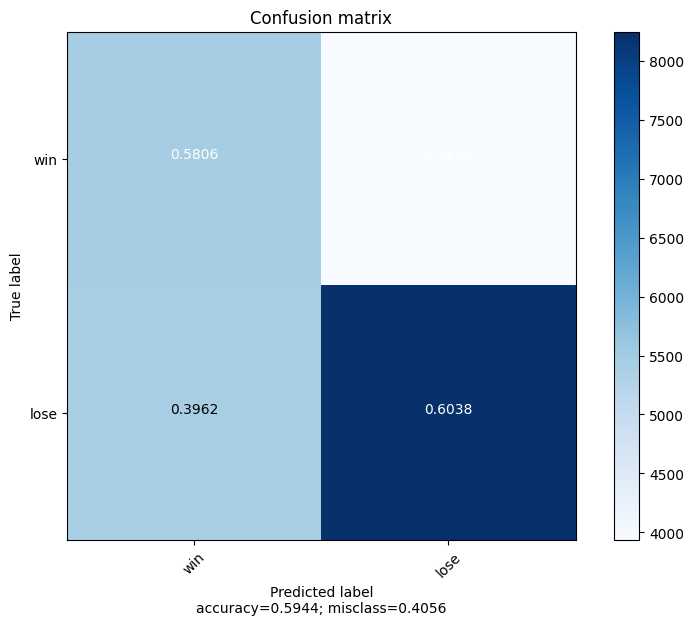

In [17]:
cm = confusion_matrix(target, train_oof_binary)
print(cm)
fig = plot_confusion_matrix(cm,['win','lose'])
run["train/confusion_matrix"].upload(fig)


**OOF Classification report**

In [18]:
run["train/classification_report"] = classification_report(target, train_oof_binary)
print(classification_report(target, train_oof_binary))

              precision    recall  f1-score   support

         0.0       0.50      0.58      0.54      9384
         1.0       0.68      0.60      0.64     13663

    accuracy                           0.59     23047
   macro avg       0.59      0.59      0.59     23047
weighted avg       0.61      0.59      0.60     23047



**Train Feature Importance via Weight - the number of times a feature appears in a tree**

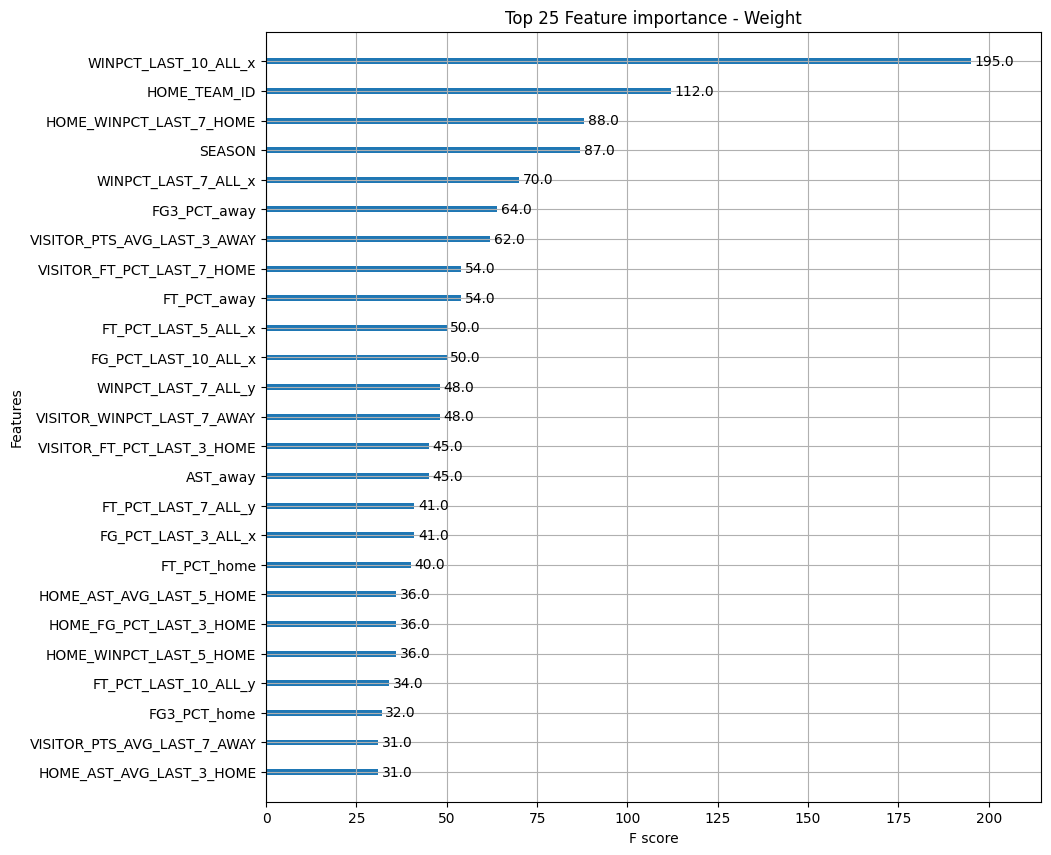

In [19]:
max_features = 25
max_title = 'Top ' + str(max_features) + ' Feature importance - Weight'
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model, importance_type='weight', max_num_features=max_features, title=max_title ,ax=ax)
run["train/feature_importance_weight"].upload(fig)

**Train Feature Importance via Gain - the average gain of splits which use the feature**

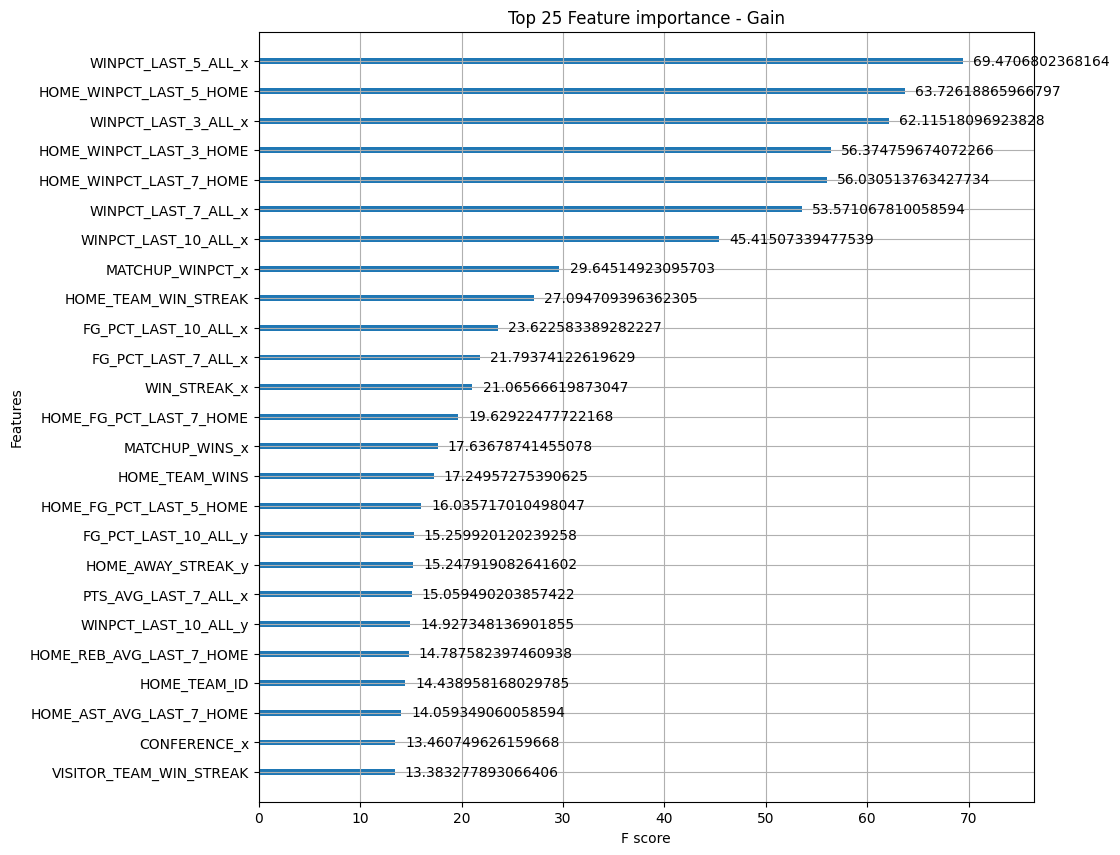

In [20]:
max_features = 25
max_title = 'Top ' + str(max_features) + ' Feature importance - Gain'
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model, importance_type='gain', max_num_features=max_features, title=max_title ,ax=ax)
run["train/feature_importance_gain"].upload(fig)

**OOF Feature Importance via Shapley values**

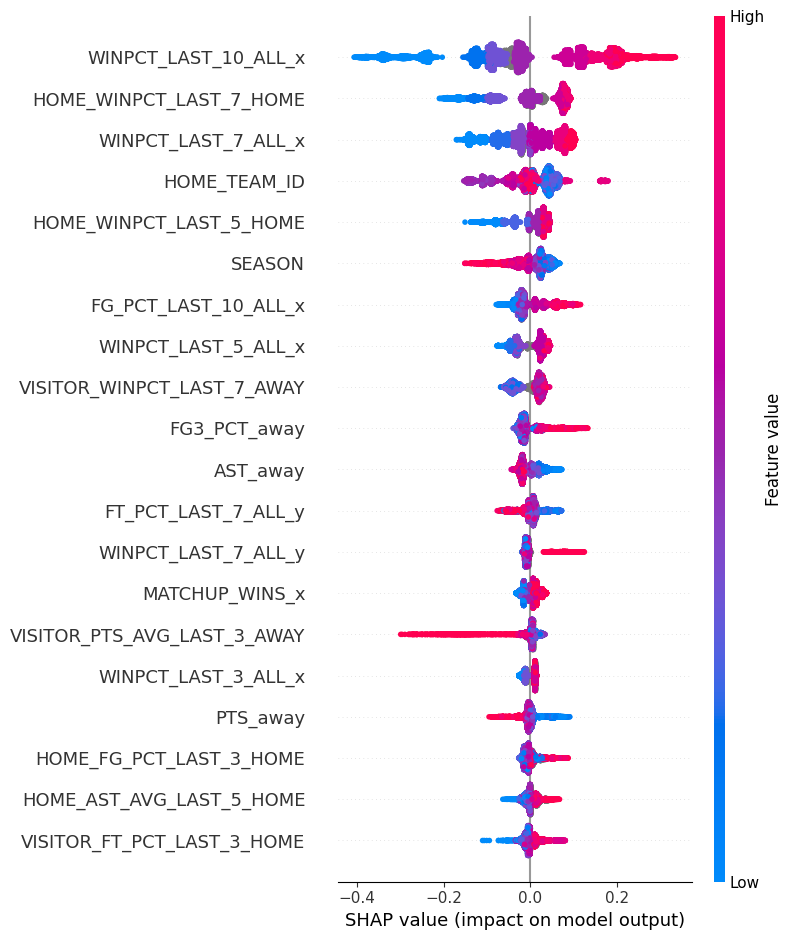

In [21]:
# summarize the effects of all the features
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(train_oof_shap[:,:-1], train)
run["train/shapley_summary"].upload(fig)

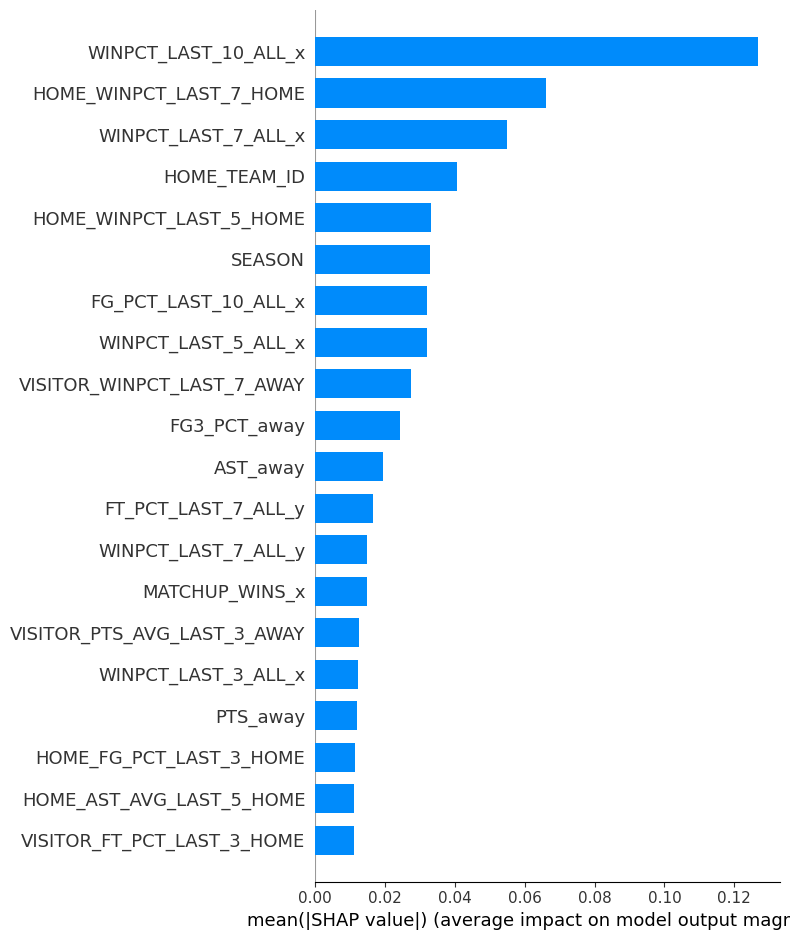

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar")
run["train/shapley_summary_bar"].upload(fig)

### Test Data Evaluation

In [23]:
test_dmatrix = xgb.DMatrix(test, enable_categorical=ENABLE_CATEGORICAL)

test_preds = model.predict(test_dmatrix)
test_preds_shap = model.predict(test_dmatrix, pred_contribs=True)

test_preds_binary, acc_score, auc_score, optimal_threshold = get_scores(test_target, test_preds)

run["test/accuracy"] = acc_score 
run["test/AUC"] = auc_score 
run["test/optimal_threshold"] = optimal_threshold

df = {'Label': 'Test', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':optimal_threshold}
results = results.append(df, ignore_index = True)         



Scores:

Accuracy Score: 0.593069306930693
AUC Score: 0.6041071428571428
Optimal Threshold: 0.9174397


**Test Confusion Matrix**

[[229 221]
 [190 370]]


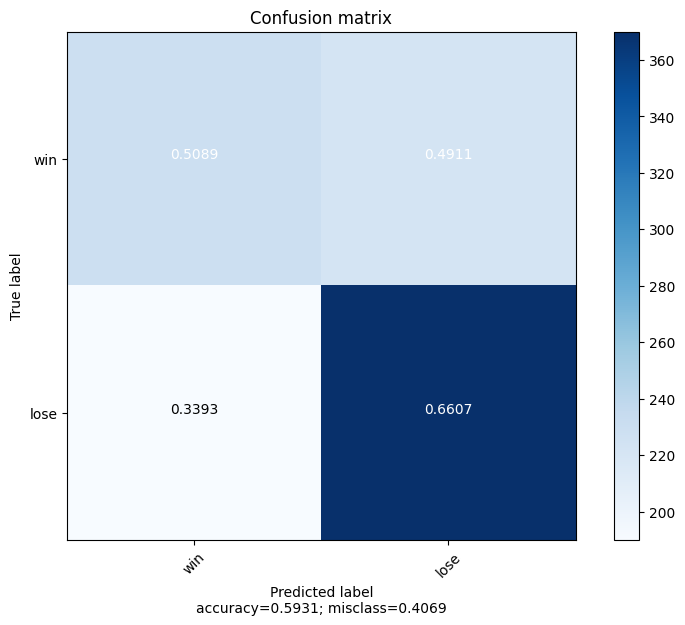

In [24]:
cm = confusion_matrix(test_target, test_preds_binary)
print(cm)
fig = plot_confusion_matrix(cm,['win','lose'])
run["test/confusion_matrix"].upload(fig)


**Test Classification report**

In [25]:
run["test/classification_report"] = classification_report(test_target, test_preds_binary)
print(classification_report(test_target, test_preds_binary))

              precision    recall  f1-score   support

         0.0       0.55      0.51      0.53       450
         1.0       0.63      0.66      0.64       560

    accuracy                           0.59      1010
   macro avg       0.59      0.58      0.58      1010
weighted avg       0.59      0.59      0.59      1010



**Test Feature Importance via Shapley values**

For comparison to cross-validation OOF Shapley values to ensure that the model is working in similar manner on the test data as train data

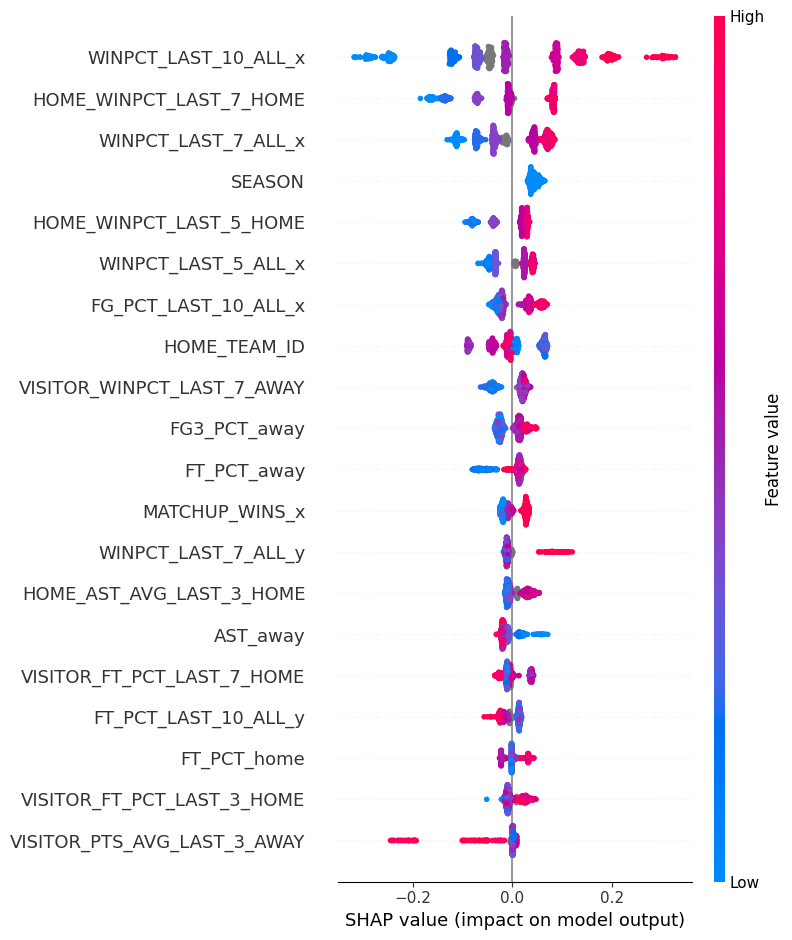

In [26]:
# summarize the effects of all the features
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(test_preds_shap[:,:-1], test)
run["test/shapley_summary"].upload(fig)

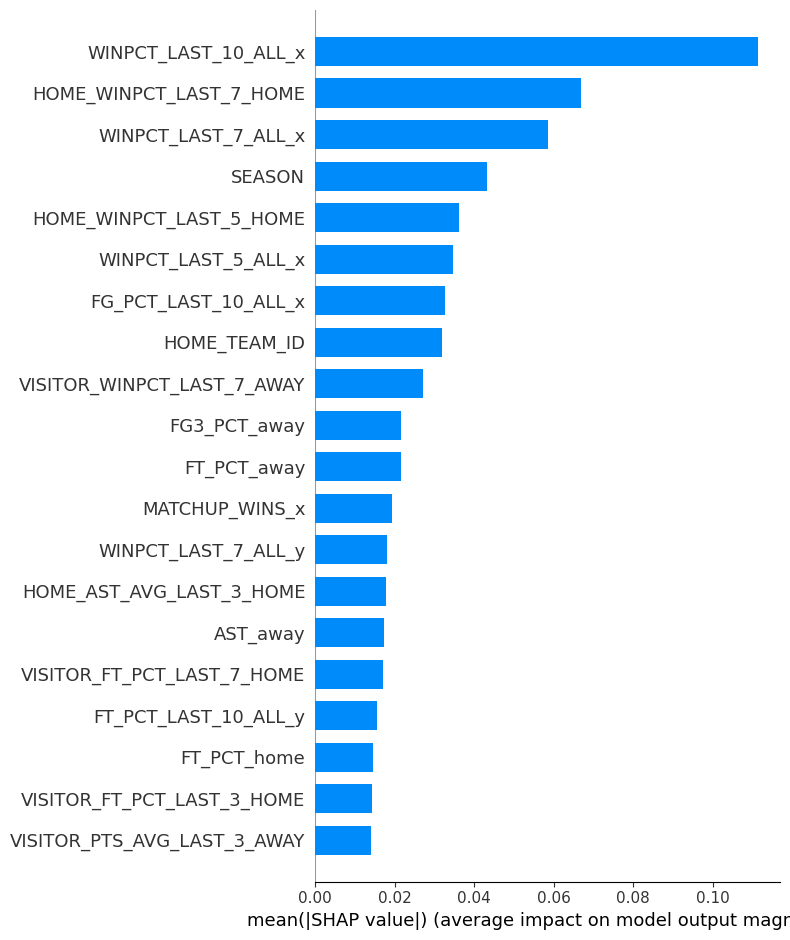

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(test_preds_shap[:,:-1], test[use_columns], plot_type="bar")
run["test/shapley_summary_bar"].upload(fig)

## Model Evaluation

 - Compare Simple model predictions vs ML Test data predictions
 - Compare OOF/Train data vs Test/Validation data
 - Compare early season Test data vs later season Test data
 
 Feature importances via Shapley values are *local* to the given dataset and can assist in adversarial validation

**Split Test data**

In [28]:
test = pd.read_csv(DATAPATH / TEST_NAME)
test = fix_datatypes(test)
test = encode_categoricals(test)

SPLIT = pd.to_datetime("2022-01-01")

run["test_split_test1/end_date"] = SPLIT
run["test_split_test2/start_date"] = SPLIT

test1 = test[test['GAME_DATE_EST'] < SPLIT]
test2 = test[test['GAME_DATE_EST'] >= SPLIT]

test1_target = test1['TARGET']
test2_target = test2['TARGET']

test1 = test1[use_columns]
test2 = test2[use_columns]

**Process Splits**

TEST1

Scores:

Accuracy Score: 0.5464895635673624
AUC Score: 0.5829186672486542
Optimal Threshold: 0.9322967
              precision    recall  f1-score   support

         0.0       0.50      0.75      0.60       237
         1.0       0.65      0.38      0.48       290

    accuracy                           0.55       527
   macro avg       0.57      0.57      0.54       527
weighted avg       0.58      0.55      0.53       527



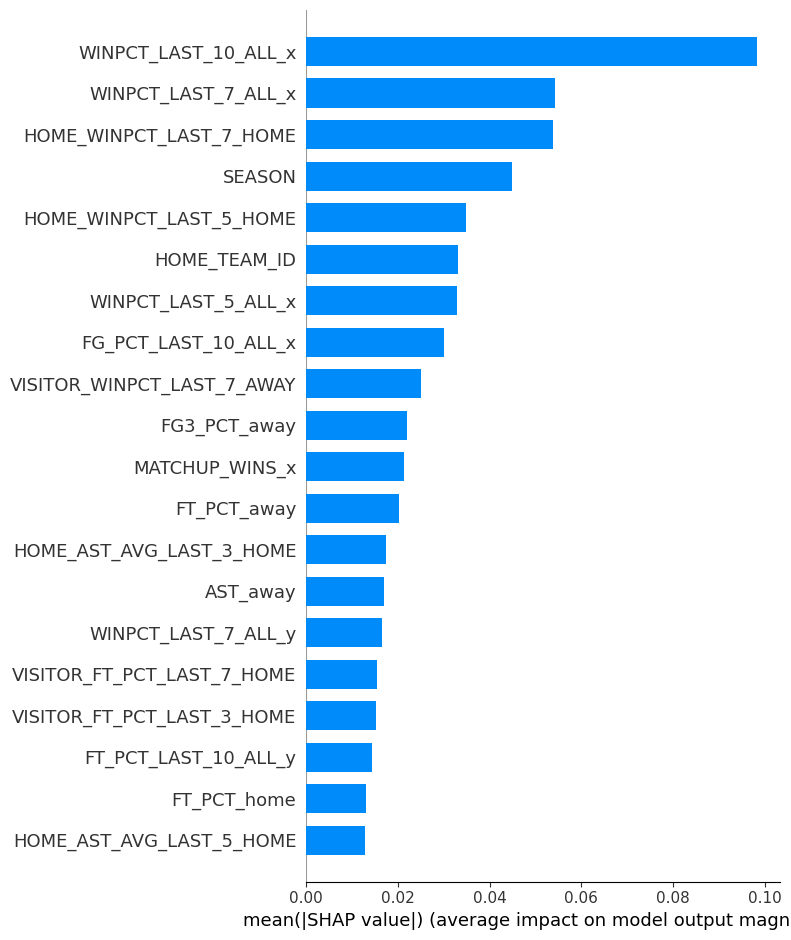

TEST2

Scores:

Accuracy Score: 0.6149068322981367
AUC Score: 0.6189706138062945
Optimal Threshold: 0.9180354
              precision    recall  f1-score   support

         0.0       0.57      0.54      0.56       213
         1.0       0.65      0.67      0.66       270

    accuracy                           0.61       483
   macro avg       0.61      0.61      0.61       483
weighted avg       0.61      0.61      0.61       483



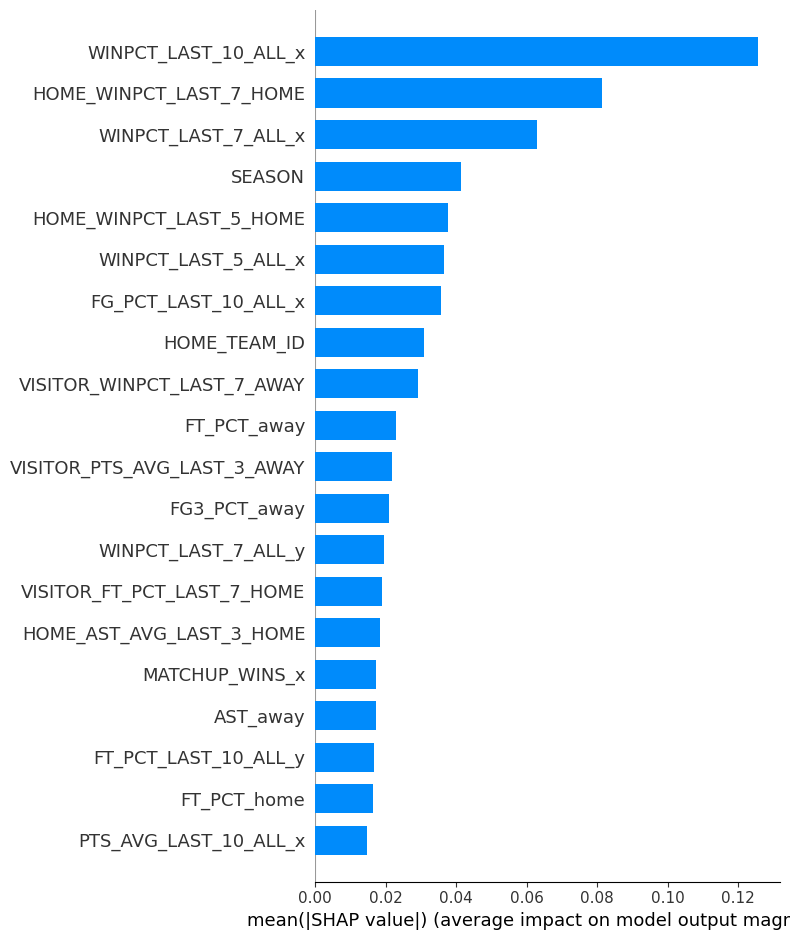

In [29]:
def process_splits(label, test, test_target, results):

    test_dmatrix = xgb.DMatrix(test, enable_categorical=ENABLE_CATEGORICAL)

    test_preds = model.predict(test_dmatrix)
    test_preds_shap = model.predict(test_dmatrix, pred_contribs=True)

    test_preds_binary, acc_score, auc_score, optimal_threshold = get_scores(test_target, test_preds)

    run["test_split_" + label + "/accuracy"] = acc_score 
    run["test_split_" + label + "/AUC"] = auc_score 
    run["test_split_" + label + "/optimal_threshold"] = optimal_threshold

    df = {'Label': label, 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':optimal_threshold}
    results = results.append(df, ignore_index = True) 

    run["test_split_" + label + "/classification_report"] = classification_report(test_target, test_preds_binary)
    print(classification_report(test_target, test_preds_binary))
    
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    shap.summary_plot(test_preds_shap[:,:-1], test, plot_type="bar")
    run["test_split_" + label + "/shapley_summary_bar"].upload(fig)

    #Simple model applied to split
    acc_score, auc_score = SimpleModel(test, test_target)
    df = {'Label': 'Simple-' + label, 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':"N/A"}
    results = results.append(df, ignore_index = True) 
    
    return test_preds_shap, results
    
print("TEST1")
test_preds_shap1, results = process_splits('Test1',test1, test1_target, results)
print("TEST2")
test_preds_shap2, results = process_splits('Test2',test2, test2_target, results)


**Summary Table**

Key metrics from Simple Model, Train, Test, and Test-split

In [30]:
run["evaluation/summary_table"].upload(File.as_html(results))
results

Label  Accuracy       AUC Threshold
0  Simple Model  0.569307  0.558571       N/A
1         Train  0.594351  0.622584  0.920341
2          Test  0.593069  0.604107   0.91744
3         Test1  0.546490  0.582919  0.932297
4  Simple-Test1  0.565465  0.553892       N/A
5         Test2  0.614907  0.618971  0.918035
6  Simple-Test2  0.573499  0.564006       N/A

**Train vs Test Feature Importances via Shapley Values**

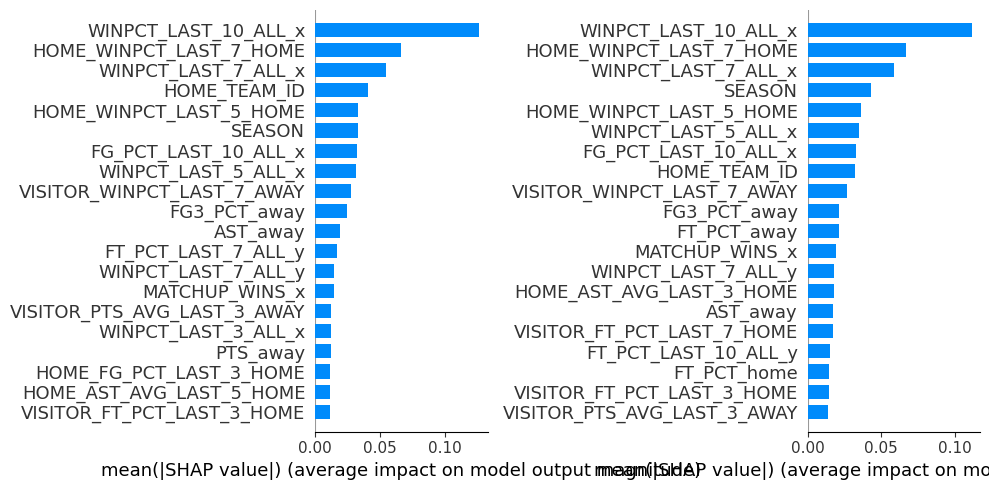

In [31]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar", plot_size=None, show=False)
plt.subplot(1,2,2)
shap.summary_plot(test_preds_shap[:,:-1], test1[use_columns], plot_type="bar", plot_size=None, show=False)
plt.tight_layout()
fig.show()
run["evaluation/test_train_shapley_summary_bar"].upload(fig)

**Test1 vs Test2 Feature Importances via Shapley Values**

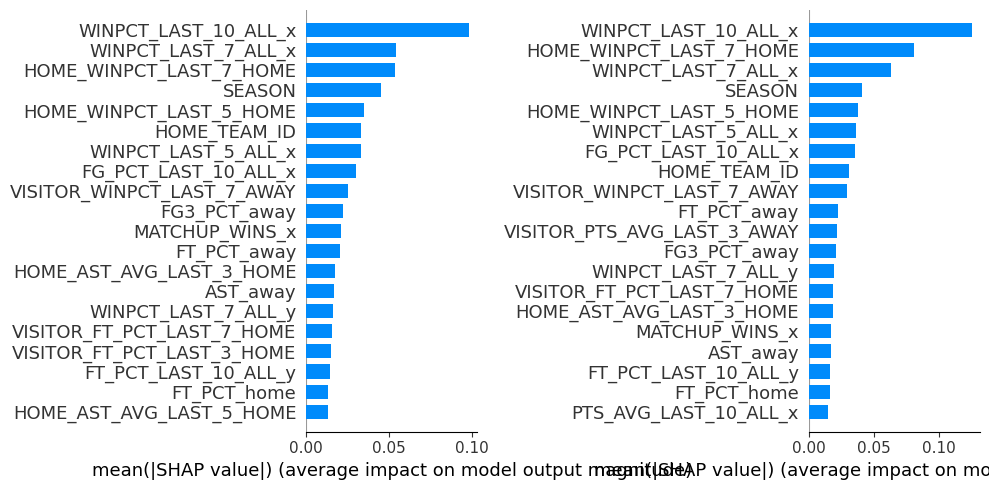

In [32]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
shap.summary_plot(test_preds_shap1[:,:-1], test1[use_columns], plot_type="bar", plot_size=None, show=False)
plt.subplot(1,2,2)
shap.summary_plot(test_preds_shap2[:,:-1], test1[use_columns], plot_type="bar", plot_size=None, show=False)
plt.tight_layout()
fig.show()
run["evaluation/test1_test2_shapley_summary_bar"].upload(fig)

**End experiment tracking**

In [33]:
#end experiment tracking
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 88 operations to synchronize with Neptune. Do not kill this process.
All 88 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/cmunch1/nba-prediction/e/NBAP-4
